# Hòa phát group 80 -20

## Xử lý dữ liệu

In [24]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.layers import Dense, GRU

from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import DecisionTreeRegressor
from sklearn.metrics import accuracy_score

# 2. Đọc file csv và gắng index với giá Price
df = pd.read_csv('HPG Historical Data.csv',sep=",")
df1 = df.reset_index()['Price']

# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(0.2 * len(df1))
train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

# 5. Hàm Create Dataset (convert an array of values into a dataset matrix)
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

## Model  

In [8]:
# Define the GRU model
def create_gru_model():
    model = Sequential()
    model.add(GRU(64, input_shape=(time_step, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Create and train multiple GRU models
n_estimators = 10
predictions = []

for _ in range(n_estimators):
    base_model = create_gru_model()
    base_model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=0)
    y_pred = base_model.predict(X_test)
    predictions.append(y_pred.flatten())
    
# Average the predictions
bagging_predictions = np.mean(predictions, axis=0)

# Inverse transform the predictions
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
bagging_predictions_inv = scaler.inverse_transform(bagging_predictions.reshape(-1, 1))


c:\Users\hangt\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step
2/5 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001E495D104A0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step
5/5

## Visualize model

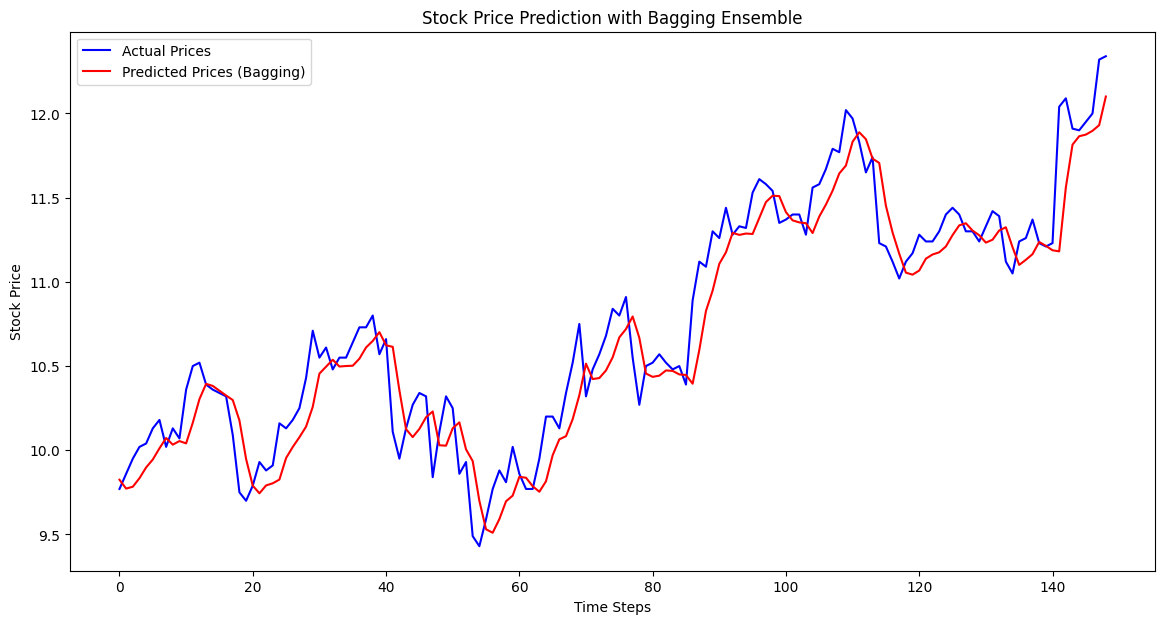

In [15]:
# Visualize the results
plt.figure(figsize=(14, 7))
plt.plot(y_test_inv, label='Actual Prices', color='blue')
plt.plot(bagging_predictions_inv, label='Predicted Prices (Bagging)', color='red')
plt.title('Stock Price Prediction with Bagging Ensemble')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## Đánh giá model

In [32]:
test_mae = np.mean(abs(bagging_predictions_inv - true_values_testing))
print('Testing MAE:', test_mae)

Testing MAE: 0.17085727179610502


In [ ]:

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn import metrics
import numpy as np

# Inverse transform the true values for the testing data
true_values_testing = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE for testing data
rmse_testing = np.sqrt(mean_squared_error(true_values_testing, bagging_predictions_inv))
print(f'Testing RMSE: {rmse_testing}')

# Calculate MAPE for testing data
mape_testing = mean_absolute_percentage_error(true_values_testing, bagging_predictions_inv) * 100
print(f'Testing MAPE: {mape_testing}')

# Calculate MLSE for testing data
mlse_testing = np.mean(np.log1p(true_values_testing) - np.log1p(bagging_predictions_inv))**2
print(f'Testing MLSE: {mlse_testing}')


Testing RMSE: 0.2200618315231874
Testing MAPE: 1.5939931137436352
Testing MLSE: 4.734709851697101e-05


In [ ]:
from sklearn.metrics import mean_squared_error as MSE 
from sklearn.metrics import mean_absolute_error as MAE 
from sklearn.metrics import r2_score
print('MAE:', MAE(true_values_testing,bagging_predictions_inv))
print("RMSE:", MSE(true_values_testing,bagging_predictions_inv, squared = False))
print("MSE:", MSE(true_values_testing,bagging_predictions_inv))
print('R_squared:', r2_score(true_values_testing,bagging_predictions_inv))

MAE: 0.17085727179610502


c:\Users\hangt\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE: 0.2200618315231874
MSE: 0.04842720969333972
R_squared: 0.8979932147184091


## Dự đoán 30 - 60 - 90 ngày tiếp theo

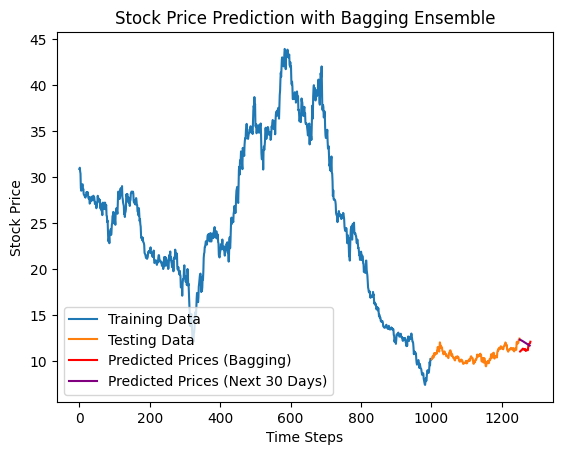

In [16]:

# Predict for the next 30 days
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])
lst_output = []

for i in range(30):
    if len(temp_input) > time_step:

        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))

        yhat = base_model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        lst_output.extend(yhat.tolist())
    else:
        x_input = x_input.reshape((1, time_step, 1))
        yhat = base_model.predict(x_input, verbose=0)

        temp_input.extend(yhat[0].tolist())

# Inverse transform the predictions for the next 30 days
final_predictions = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))

# Plot the training data
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data),label='Training Data')

# Plot the testing data
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data),label='Testing Data')

# Plot the predicted prices with bagging
plt.plot(np.arange(len(df1), len(df1) + 30), bagging_predictions_inv[-30:], label='Predicted Prices (Bagging)', color='red')

# Plot the predicted prices for the next 30 days
next_30_days_index = pd.RangeIndex(start=train_size + test_size, stop=train_size + test_size + 29, step=1)
plt.plot(next_30_days_index, final_predictions, label='Predicted Prices (Next 30 Days)', color='purple')

plt.title('Stock Price Prediction with Bagging Ensemble')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()